http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

In [5]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')


stock_data = pd.read_csv('BANKNIFTY.csv')
stock_data['Date'] = stock_data['Date'].convert_objects(convert_dates='coerce')
stock_data = stock_data.sort_index(by='Date')
stock_data = stock_data.set_index('Date')

/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':
/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  del sys.path[0]


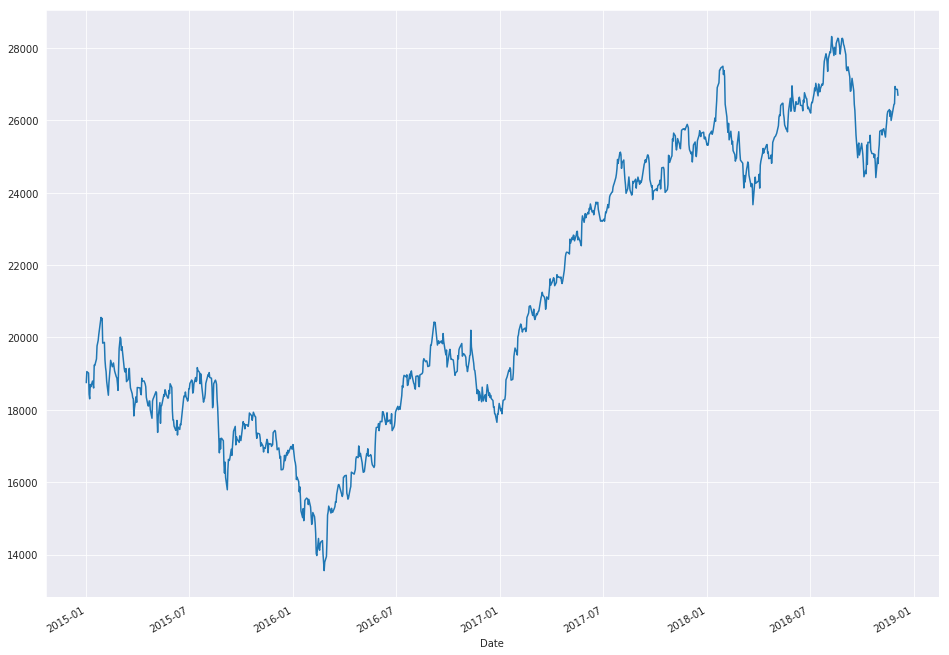

In [7]:
stock_data['Close'].plot(figsize=(16, 12))

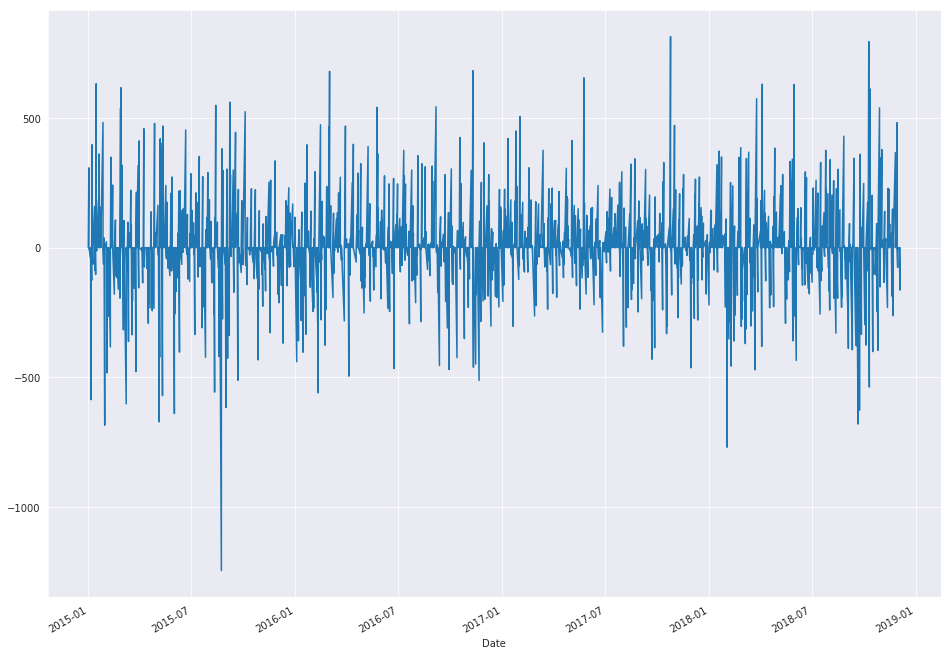

In [6]:
stock_data['First Difference'] = stock_data['Close'] - stock_data['Close'].shift()
stock_data['First Difference'].plot(figsize=(16, 12))

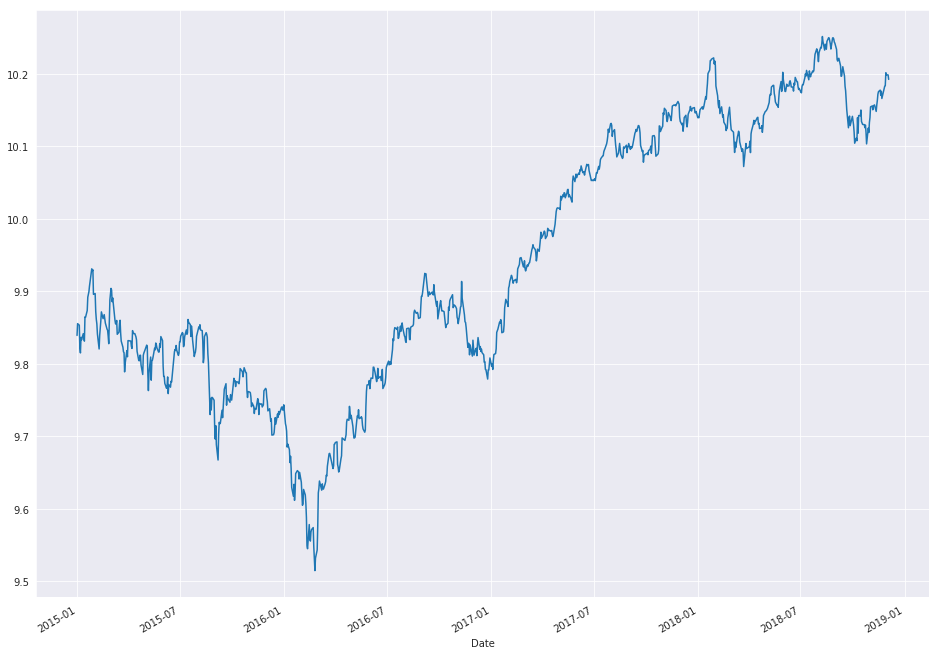

In [8]:
stock_data['Natural Log'] = stock_data['Close'].apply(lambda x: np.log(x))
stock_data['Natural Log'].plot(figsize=(16, 12))

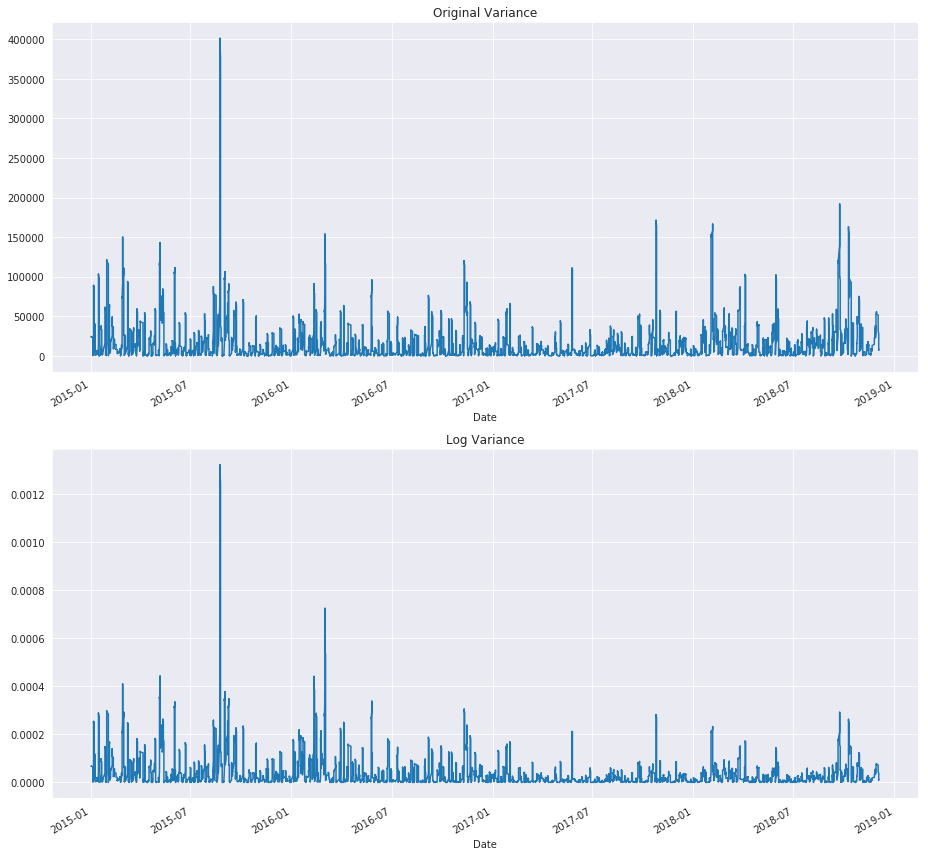

In [13]:
stock_data['Original Variance'] = stock_data['Close'].rolling(30).var()
stock_data['Log Variance'] = stock_data['Natural Log'].rolling(30).var()
fig, ax = plt.subplots(2, 1, figsize=(13, 12))
stock_data['Original Variance'].plot(ax=ax[0], title='Original Variance')
stock_data['Log Variance'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout()

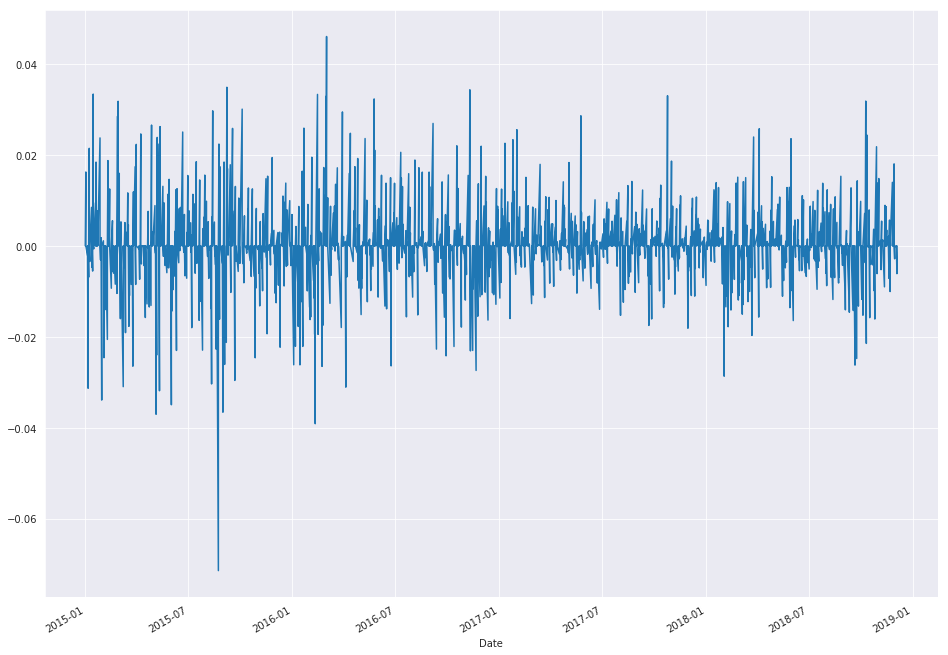

In [14]:
stock_data['Logged First Difference'] = stock_data['Natural Log'] - stock_data['Natural Log'].shift()
stock_data['Logged First Difference'].plot(figsize=(16, 12))

Much better! We now have a stationary time series model

Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

In [15]:
stock_data['Lag 1'] = stock_data['Logged First Difference'].shift()
stock_data['Lag 2'] = stock_data['Logged First Difference'].shift(2)
stock_data['Lag 5'] = stock_data['Logged First Difference'].shift(5)
stock_data['Lag 30'] = stock_data['Logged First Difference'].shift(30)

/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


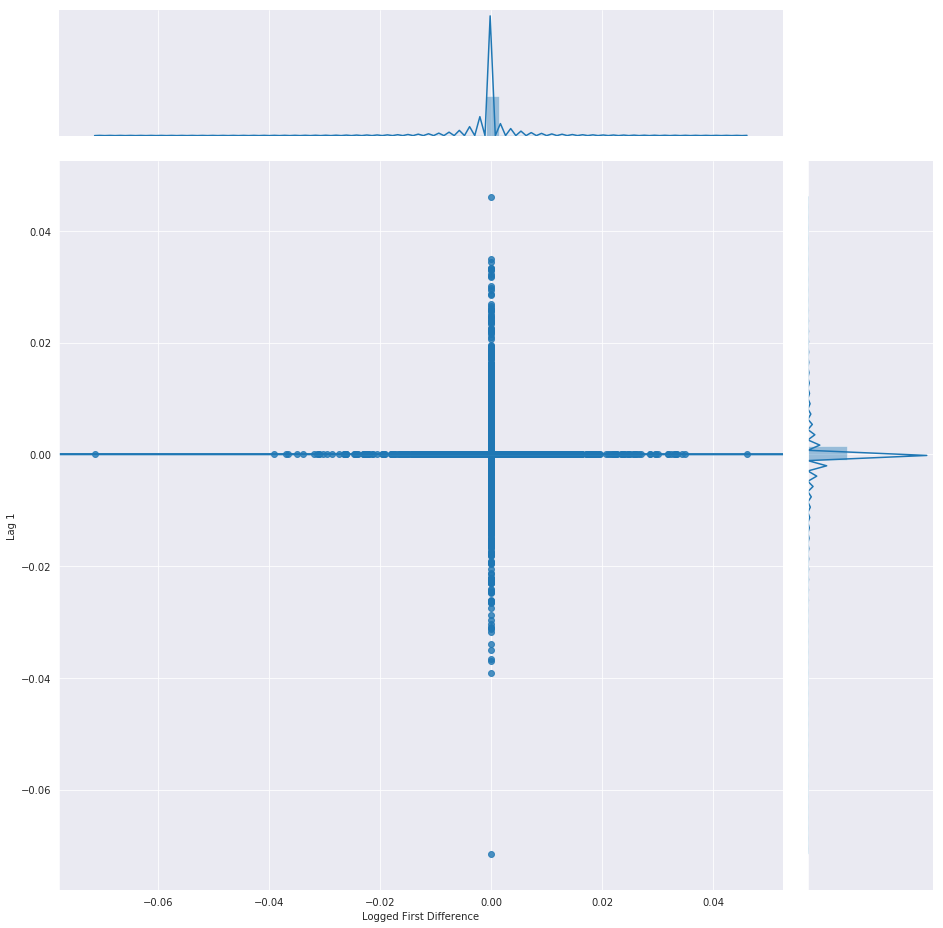

In [16]:
sb.jointplot('Logged First Difference', 'Lag 1', stock_data, kind='reg', size=13)

In [17]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['Logged First Difference'].iloc[1:])
lag_partial_correlations = pacf(stock_data['Logged First Difference'].iloc[1:])

The auto-correlation function computes the correlation between a variable and itself at each lag step up to some limit (in this case 40). The partial auto-correlation function computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps. We can plot the results to see if there are any significant correlations.

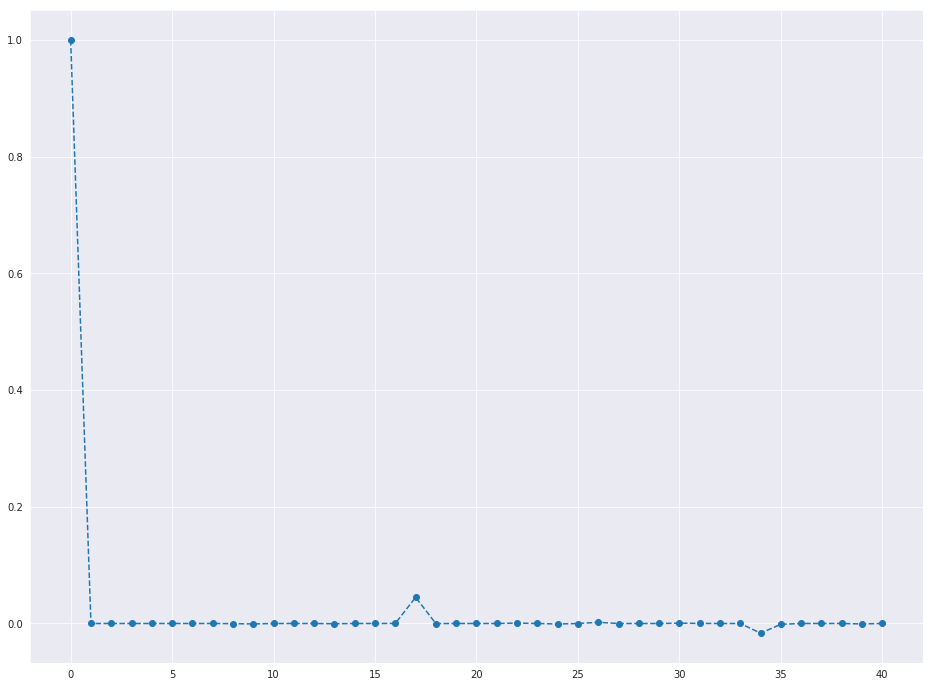

In [18]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(lag_correlations, marker='o', linestyle='--')

The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above). What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk.


Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.

<Figure size 432x288 with 0 Axes>

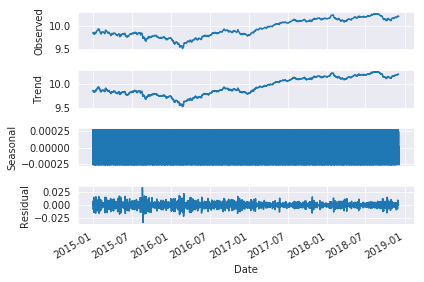

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Natural Log'], model='additive', freq=30)
fig = plt.figure()
fig = decomposition.plot()

Since we don't see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal pattern though it can be very useful. The folling instance, for example, is a sample from the statsmodels documentation showing CO2 emissions data over time.

https://www.johnwittenauer.net/a-simple-time-series-analysis-of-the-sp-500-index/

we're already observed that it's a random walk and that our lagged variables don't seem to have much impact, but we can still try fitting some ARIMA models and see what we get. Let's start with a simple moving average model.

/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


16433
16434


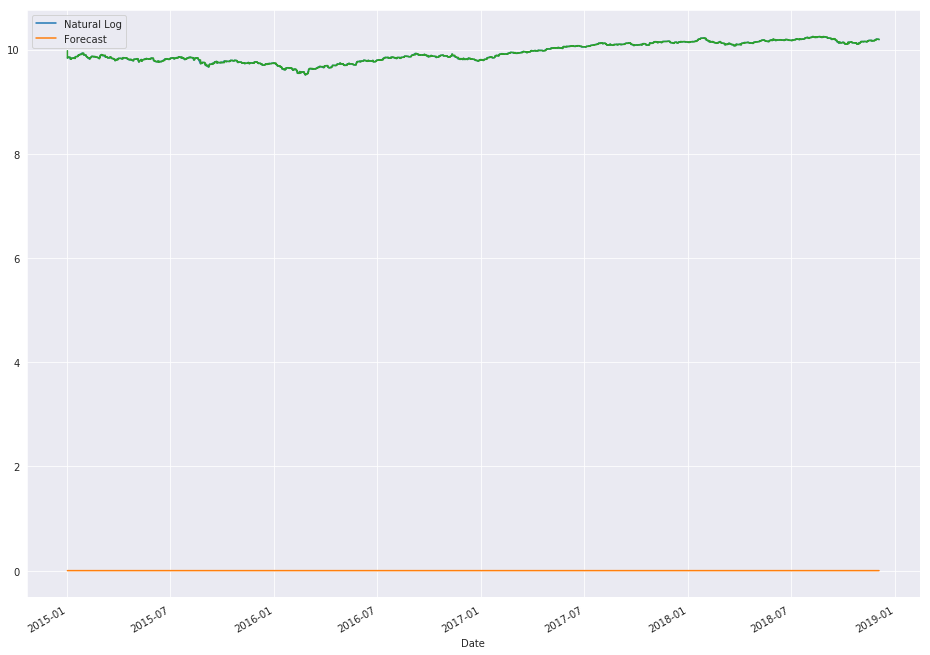

In [30]:
model = sm.tsa.ARIMA(stock_data['Natural Log'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
results.fittedvalues
print(len(results.fittedvalues))
print(len(stock_data['Natural Log']))
stock_data['Forecast'] = 0
#stock_data['Forecast'] = results.fittedvalues
stock_data[['Natural Log', 'Forecast']].plot(figsize=(16, 12))
results.fittedvalues.plot(figsize=(16, 12))


/Users/sanjotraibagkar/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


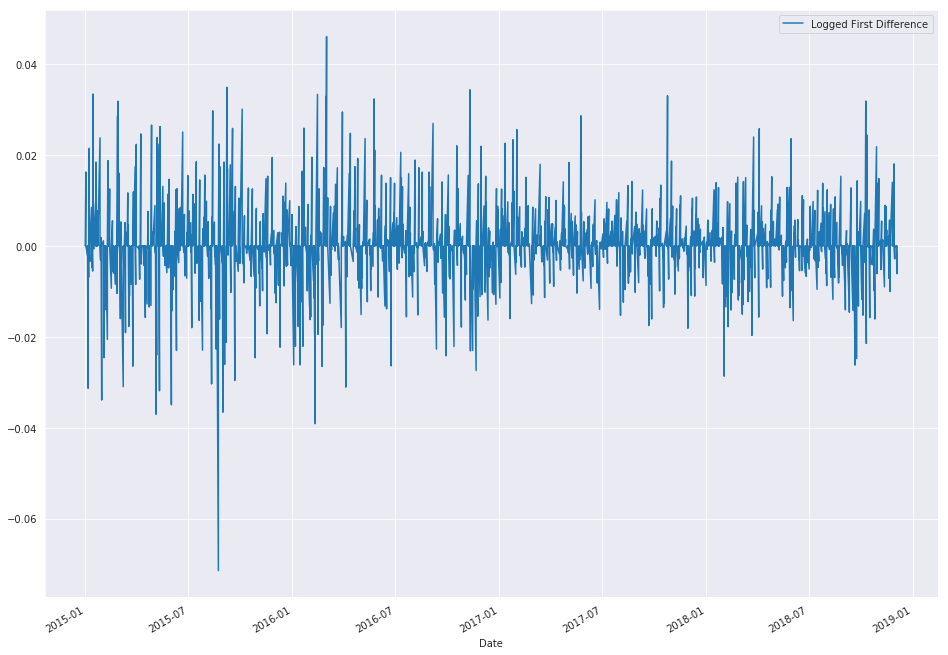

In [32]:
model = sm.tsa.ARIMA(stock_data['Logged First Difference'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
#stock_data['Forecast'] = results.fittedvalues
stock_data[['Logged First Difference']].plot(figsize=(16, 12))
